In [18]:
import numpy as np
from skimage import io
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from skimage.exposure import histogram
from matplotlib.pyplot import bar
from skimage.color import rgb2gray, rgb2hsv

# Convolution:
from scipy.signal import convolve2d
from scipy import fftpack
import math

from skimage.util import random_noise
from skimage.filters import median, threshold_otsu
from skimage.feature import canny

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

# Edges
from skimage.filters import sobel_h, sobel, sobel_v, roberts, prewitt

# DataSetPATH = "../input/fonts-dataset-cmp/fonts-dataset" # for kaggle
DataSetPATH = "./Dataset" # for local

In [19]:
# Show the figures / plots inside the notebook
def show_images(images, titles=None):
    # This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None:
        titles = ["(%d)" % i for i in range(1, n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image, title in zip(images, titles):
        a = fig.add_subplot(1, n_ims, n)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        plt.axis("off")
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()


def show_3d_image(img, title):
    fig = plt.figure()
    fig.set_size_inches((12, 8))
    ax = fig.gca(projection="3d")

    # Make data.
    X = np.arange(0, img.shape[0], 1)
    Y = np.arange(0, img.shape[1], 1)
    X, Y = np.meshgrid(X, Y)
    Z = img[X, Y]

    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

    # Customize the z axis.
    ax.set_zlim(0, 8)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter("%.02f"))

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.set_title(title)
    plt.show()


def show_3d_image_filtering_in_freq(img, f):
    img_in_freq = fftpack.fft2(img)
    filter_in_freq = fftpack.fft2(f, img.shape)
    filtered_img_in_freq = np.multiply(img_in_freq, filter_in_freq)

    img_in_freq = fftpack.fftshift(np.log(np.abs(img_in_freq) + 1))
    filtered_img_in_freq = fftpack.fftshift(np.log(np.abs(filtered_img_in_freq) + 1))

    show_3d_image(img_in_freq, "Original Image")
    show_3d_image(filtered_img_in_freq, "Filtered Image")


def showHist(img):
    # An "interface" to matplotlib.axes.Axes.hist() method
    plt.figure()
    imgHist = histogram(img, nbins=256)
    bar(imgHist[1].astype(np.uint8), imgHist[0], width=0.8, align="center")


In [20]:
def ThresholdImage(image,Trace=False):
    img=image.copy()
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # use THRESH_OTSU to detect the threshold value automatically
    img = cv.threshold(img, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)[1]
    num_ones = np.count_nonzero(img)
    num_zeros = img.size - num_ones

    # it means that background is white and text is black
    if num_ones > num_zeros:
        img = cv.bitwise_not(img)
    if Trace:
        print(num_ones, num_zeros)
        show_images([img], ["Thresholded Image White background and Black text"])
    return img

In [21]:
def RemoveSaltPepperNoise(image,Trace=False):
    img = image.copy()
    # Remove Salt and Pepper Noise
    img = cv.medianBlur(img, 3)
    if Trace:
        show_images([img], ["Image after removing Salt and Pepper Noise"])
    return img

In [22]:
def DeskewImage(image,Trace=False):
    original = image.copy()
    img = image.copy()
    thresh = cv.GaussianBlur(img, (9, 9), 0)
    # Resize the image with a fixed height.
    resized_height = 480
    percent = resized_height / len(img)
    resized_width = int(percent * len(img[0]))
    thresh = cv.resize(thresh, (resized_width, resized_height))

    # Draw a rectangle around the border to remove border lines.
    start_point = (0, 0) 
    end_point = (thresh.shape[0], thresh.shape[1])
    color = (255, 255, 255) 
    thickness = 10
    thresh = cv.rectangle(thresh, start_point, end_point, color, thickness)
    if Trace:
        io.imshow(thresh)
        io.show()

    # Dilate the text to make the text lines more obvious.
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (30, 5))
    dilate = cv.dilate(thresh, kernel)
    if Trace:
        io.imshow(dilate)
        io.show()
    # Find all the contours based on the dilated image.
    contours, hierarchy = cv.findContours(
        dilate, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE
    )

    # show the contours
    if Trace:
        img = cv.drawContours(original, contours, -1, (0, 255, 0), 5)
        show_images([img], ["Contours"])

    # Use minAreaRect to get the rotation angles of contours.
    angles = []
    for contour in contours:
        minAreaRect = cv.minAreaRect(contour)
        angle = minAreaRect[-1]
        if angle != 90.0 and angle != -0.0: #filter out 0 and 90
            angles.append(angle)

    angles.sort()
    # Use the median as the skewed angle.
    print(int(len(angles) / 2))
    mid_angle = angles[int(len(angles)/2)] if len(angles)!=0 else 0
    if Trace:
        print(angles)
        print(angle)
        print(mid_angle)
    # # Rotate the image to deskew the text.
    # if angle > 45:  # anti-clockwise
    #     angle = -(90 - angle)
    height = original.shape[0]
    width = original.shape[1]
    m = cv.getRotationMatrix2D((width / 2, height / 2), mid_angle, 1)
    deskewed = cv.warpAffine(original, m, (width, height), borderValue=(0,0,0))

    return deskewed

In [23]:
def Preprocessing(image,trace=False):
    img = image.copy()
    # Remove Salt and Pepper Noise
    img = RemoveSaltPepperNoise(img, trace)
    # Threshold the image
    img = ThresholdImage(img, trace)
    # Deskew the image
    deskewed = DeskewImage(img, trace)
    return deskewed

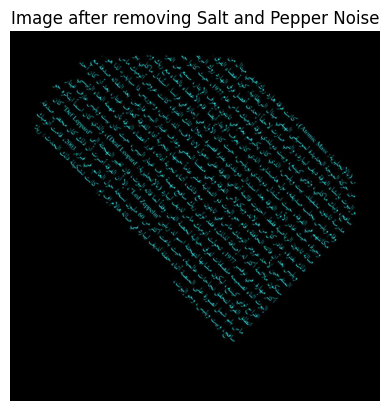

56128 1338633


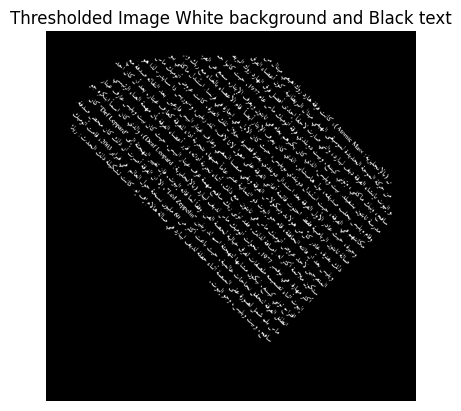

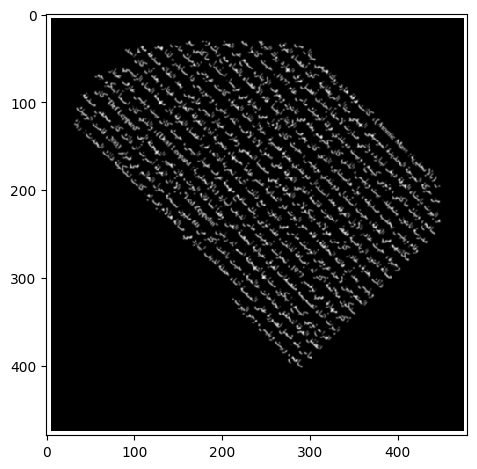

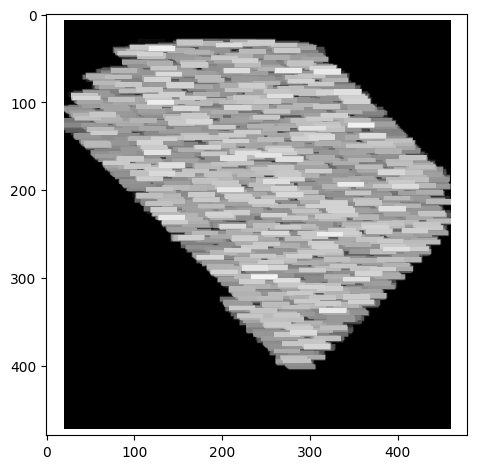

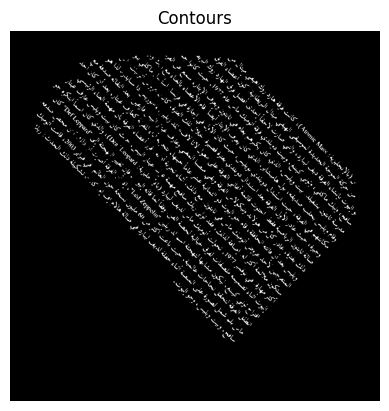

0

[45.0]

90.0

45.0


In [24]:
img = io.imread(f"{DataSetPATH}/Scheherazade New/544.jpeg")
# showHist(img)
# io.imshow(img)

# corrected = RemoveSaltPepperNoise(img, True)
corrected = Preprocessing(img, True)


# showImage(corrected,"Corrected Image")
# io.imsave("corrected.jpg", corrected)
# io.imshow(corrected)